In [160]:
!pip3 install torch torchvision torchaudio onnx onnxruntime pillow fastapi uvicorn python-multipart

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as TUtils
import torchvision.transforms as T
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import pathlib
import onnxruntime as ort
import io
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
import nest_asyncio
import uvicorn

In [162]:
device = torch.accelerator.current_acceleartor() if torch.accelerator.is_available() else "cpu"

In [163]:
train_transforms = T.Compose([
    T.Resize((32, 32)),              
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))      
])

test_transforms = T.Compose([
    T.Resize((32, 32)),             
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

batch_size = 64

trainset = datasets.ImageFolder(root='data/train', transform=train_transforms)

trainloader = DataLoader(trainset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

testset = datasets.ImageFolder(root='data/test', transform=test_transforms)

testloader = DataLoader(testset, batch_size=batch_size,
                       shuffle=False, num_workers=0)

for i, (img, label) in enumerate(testloader):
    print(img.shape)
    break

# Redefine classes as locations instead of objects
#location_classes = (
    #'New York', 'Paris', 'Tokyo', 'London',
    #'Sydney', 'Dubai', 'Rio', 'Cape Town', 'Venice', 'Hong Kong'
#)
location_classes = trainset.classes

torch.Size([20, 3, 32, 32])


In [164]:
class LocationNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(LocationNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.feature_dim = self._get_conv_output_dim((3, 32, 32))

        self.fc1 = nn.Linear(self.feature_dim, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def _forward_conv(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def _get_conv_output_dim(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            out = self._forward_conv(dummy_input)
            return out.view(1, -1).size(1)

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [165]:
LocationNetwork = LocationNetwork(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(LocationNetwork.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [166]:
def train(train_loader: DataLoader, model: nn.Module, criterion: nn.Module, optimizer: torch.optim):
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = LocationNetwork(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    print('Finished Training')

In [167]:
train(trainloader, LocationNetwork, criterion, optimizer)

Finished Training


In [168]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = LocationNetwork(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{location_classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  foret plage foret ville


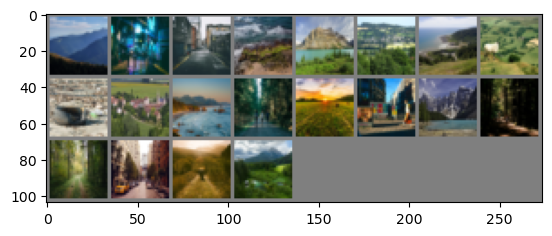

IndexError: index 20 is out of bounds for dimension 0 with size 20

In [169]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(TUtils.make_grid(images))
# print labels
print(' '.join(f'{location_classes[labels[j]]:5s}' for j in range(batch_size)))

In [170]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [171]:
epochs = 10
test_losses = []
test_accuracies = []

for t in range(epochs):
    test_losses.append(test(testloader, ImageCNNModel, criterion)[0])
    test_accuracies.append(test(testloader, ImageCNNModel, criterion)[1])
print("Test Done!")

# Plot loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), test_losses, label='Average Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
plt.legend()
plt.xticks(range(1, epochs+1))
plt.show()

# Plot accuracy per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), test_accuracies, label='Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.xticks(range(1, epochs+1))
plt.show()

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in location_classes}
total_pred = {classname: 0 for classname in location_classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = LocationNetwork(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[location_classes[label]] += 1
            total_pred[location_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[20, 3, 32, 32] to have 1 channels, but got 3 channels instead

In [172]:
PATH = './model/location_recognition.pth'
torch.save(LocationNetwork.state_dict(), PATH)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [173]:
model = LocationNetwork(num_classes=5)
model.load_state_dict(torch.load("model/location_recognition.pth", map_location=device))
model.eval()

dummy_input = torch.randn(1, 3, 32, 32)

torch.onnx.export(model, dummy_input, "location_recognition.onnx",
                  input_names=["input"], output_names=["output"],
                  opset_version=11)

print("✅ Modèle exporté en ONNX avec succès !")


TypeError: LocationNetwork.forward() got an unexpected keyword argument 'num_classes'